In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from model.random_agents import *

In [3]:
import torch 
import numpy as np
from envs import env

In [5]:
class MemoryAgentModel(torch.nn.Module):
    def __init__(self, grid_size=100, window_size=10):
        super().__init__()
        self.grid_size = grid_size
        self.window_size = window_size
        
        self.memoized_env = torch.nn.Parameter(torch.ones(grid_size, grid_size), requires_grad=False)
        self.planter = RandomPlanter("Sam",window_size)
        self.observer = RandomObserever("Mike", grid_size, window_size)
        
    def forward(self, env):
        
        x, y = self.observer.forward(env)
        
        x0, x1, y0, y1 = [x.detach().int(),x.detach().int()+self.window_size,
                          y.detach().int(),y.detach().int()+self.window_size]
        
        perception_field = self.planter.forward(env[x0:x1, y0:y1])
        memoized_env = env * self.memoized_env
        memoized_env[x0:x1, y0:y1] = perception_field
        return memoized_env, perception_field, x0, y0

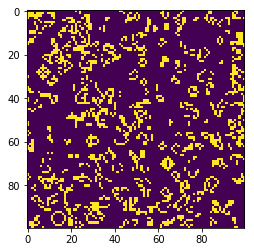

In [12]:
from IPython.display import clear_output
from time import sleep

sandbox = env.Env(grid_size=(100,100))
agent = MemoryAgentModel(100, 100)
optim = torch.optim.Adam(agent.parameters())

loss = torch.nn.L1Loss()
def loss_fn(env):
    return loss((env.shape[0]*env.shape[1]), env.sum())

print('zero field')
plt.imshow(sandbox.grid)
plt.show()

target = torch.ones(10, 10)
for i in range(30):
    memoized_env, perception_field, x0, y0 = agent.forward(torch.tensor(sandbox.grid).float())    
    env_state = sandbox.step(perception_field=perception_field.detach(), 
                             field_position_x=x0, 
                             field_position_y=y0, n_steps=10)
    print('field after agent inference')
    plt.imshow(env_state["grid"])
    plt.show()
#     sandbox.grid_update(10)
    l_loss = []
    if i % 10 == 0:
        l = loss_fn(memoized_env)
        l_loss.append(l.data)
        l.backward()
        
        optim.step()
        optim.zero_grad()
        
    clear_output(wait=True)
    
    plt.imshow(sandbox.grid)
    plt.show()
    
    

In [11]:
l_loss

[]